<a id='part_0'></a>
# <span style='color:#4682B4'>Моделирование (классический ML)</span>


# <span style='color:#4682B4'>Содержание</span>
## [Часть 1: ML модели на dataset 1](#part_1)
## [Часть 2: ML модели на dataset 2](#part_2)

<a id='part_1'></a>
## <span style='color:#4682B4'> Часть 1: ML модели на dataset 1 </span>

[ВЕРНУТЬСЯ В НАЧАЛО](#part_0)

Ссылка на датасет №1
https://www.kaggle.com/datasets/ealaxi/banksim1 	

# <span style='color:#4682B4'>Эксперименты с dataset 1</span>
### [1. Подготовка числовых данных](#part_1_1)
### [2. Подготовка категориальных данных](#part_1_2)
### [3. Избавимся от дисбаланса в классах](#part_1_3)
### [4. Выберем метрики для оценки качества моделей](#part_1_4)
### [5. Стандартизируем и подготовим данные](#part_1_5)
### [6. Обучим линейную модель LogReg Cross Validation](#part_1_6)
### [7. Выводы по модели LogReg Cross Validation](#part_1_7)
### [8. Обучим CatBoostClassifier](#part_1_8)
### [9. Выводы по модели CatBoost Classifier](#part_1_9)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
colors = ['#EE5622', '#FCBD51', '#836EA3', '#B1ACB8', '#D9CDEC', '#6E23C9', '#EF7A7A', '#EFBFA0']
sns.set_palette(sns.color_palette(colors))

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import coo_matrix, hstack
from scipy.stats import mstats

import wget
from zipfile import ZipFile
import shutil
import pickle
import warnings
warnings.filterwarnings("ignore")

In [178]:
!pip install imblearn

  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [2]:
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv('1_data/data1.zip')

In [4]:
df.head(2)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0


<a id='part_1_1'></a>
## <span style='color:#00008B'>1. Подготовка числовых данных</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

<AxesSubplot:>

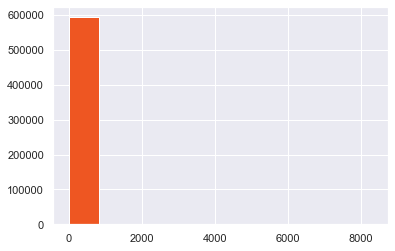

In [130]:
# Из EDA знаем что в числовой переменной amount есть выбросы
df.amount.hist()

In [5]:
# Возьмем логарифм
df.amount = np.log1p(df.amount)

<AxesSubplot:>

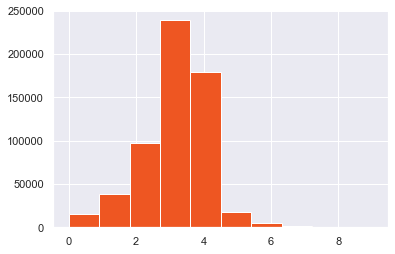

In [6]:
df.amount.hist()

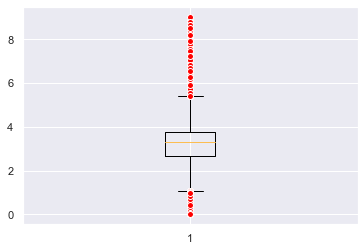

In [7]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
plt.boxplot(df.amount, flierprops=red_circle);

In [8]:
# Если взять квантиль на уровне 0.99
df[(df.amount < df.amount.quantile(0.99))].fraud.value_counts()

0    586063
1      2633
Name: fraud, dtype: int64

In [9]:
# Полные данные
df.fraud.value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

### Очевидно обрезать данные по квантилю не стоит, т.к. на уровне 0.99 квантиля порядка 5К фрода

<a id='part_1_2'></a>
## <span style='color:#00008B'>2. Подготовка категориальных данных</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

In [10]:
# Удалим неинформативные колонки
df.drop(columns=['zipMerchant', 'zipcodeOri'], inplace=True)

In [11]:
df.head(2)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',1.713798,0
1,0,'C352968107','2','M','M348934600','es_transportation',3.705737,0


#### <span style='color:#00008B'>Переменная age</span>

In [12]:
df.age.value_counts()

'2'    187310
'3'    147131
'4'    109025
'5'     62642
'1'     58131
'6'     26774
'0'      2452
'U'      1178
Name: age, dtype: int64

In [13]:
df[df.fraud == 1].age.value_counts()

'2'    2344
'3'    1755
'4'    1410
'1'     689
'5'     686
'6'     261
'0'      48
'U'       7
Name: age, dtype: int64

#### <span style='color:#00008B'>Переменная gender</span>

In [14]:
df.gender.value_counts()

'F'    324565
'M'    268385
'E'      1178
'U'       515
Name: gender, dtype: int64

In [15]:
df[df.fraud == 1].gender.value_counts()

'F'    4758
'M'    2435
'E'       7
Name: gender, dtype: int64

Гендер U можно удалить, поскольку нет ни одного фрода с его участием

In [16]:
df.drop(index=df[df.gender.str.contains('U')].index.tolist(), inplace=True)

#### <span style='color:#00008B'>Переменная merchant</span>

In [17]:
df.merchant.value_counts()

'M1823072687'    299347
'M348934600'     205327
'M85975013'       26228
'M1053599405'      6809
'M151143676'       6370
'M855959430'       6096
'M1946091778'      5339
'M1913465890'      3979
'M209847108'       3813
'M480139044'       3508
'M349281107'       2877
'M1600850729'      2622
'M1535107174'      1868
'M980657600'       1769
'M78078399'        1608
'M1198415165'      1580
'M840466850'       1396
'M1649169323'      1173
'M547558035'        949
'M50039827'         916
'M1888755466'       912
'M692898500'        900
'M1400236507'       774
'M1842530320'       750
'M732195782'        608
'M97925176'         599
'M45060432'         573
'M1741626453'       528
'M1313686961'       527
'M1872033263'       525
'M1352454843'       370
'M677738360'        358
'M2122776122'       341
'M923029380'        323
'M3697346'          308
'M17379832'         282
'M1748431652'       274
'M1873032707'       250
'M2011752106'       244
'M1416436880'       219
'M1294758098'       191
'M1788569036'   

In [18]:
df[df.fraud == 1].merchant.value_counts()

'M480139044'     1634
'M980657600'     1472
'M732195782'      518
'M1198415165'     358
'M3697346'        290
'M855959430'      280
'M1888755466'     228
'M1873032707'     216
'M2122776122'     200
'M1741626453'     196
'M1294758098'     184
'M17379832'       178
'M1535107174'     174
'M2011752106'     166
'M840466850'      158
'M1649169323'     124
'M151143676'      120
'M547558035'      116
'M209847108'      106
'M923029380'      102
'M857378720'       92
'M1353266412'      64
'M50039827'        46
'M78078399'        44
'M1748431652'      36
'M2080407379'      36
'M495352832'       24
'M692898500'       16
'M933210764'       12
'M348875670'       10
Name: merchant, dtype: int64

Можно оставить эту переменную так

#### <span style='color:#00008B'>Переменная category</span>

In [19]:
df.category.value_counts()

'es_transportation'        504674
'es_food'                   26228
'es_health'                 16112
'es_wellnessandbeauty'      15081
'es_fashion'                 6448
'es_barsandrestaurants'      6370
'es_hyper'                   6096
'es_sportsandtoys'           4002
'es_tech'                    2365
'es_home'                    1984
'es_hotelservices'           1744
'es_otherservices'            912
'es_contents'                 885
'es_travel'                   728
'es_leisure'                  499
Name: category, dtype: int64

In [20]:
df[df.fraud == 1].category.value_counts()

'es_sportsandtoys'         1982
'es_health'                1696
'es_wellnessandbeauty'      718
'es_travel'                 578
'es_hotelservices'          548
'es_leisure'                474
'es_home'                   302
'es_hyper'                  280
'es_otherservices'          228
'es_tech'                   158
'es_barsandrestaurants'     120
'es_fashion'                116
Name: category, dtype: int64

Также можно оставить эту переменную без изменений

<a id='part_1_3'></a>
## <span style='color:#00008B'>3. Избавимся от дисбаланса в классах</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

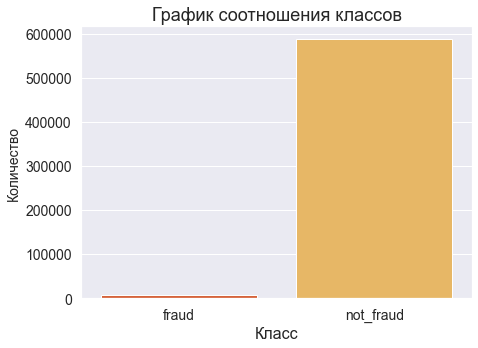

In [21]:
plt.figure(figsize=(7,5))
sns.countplot(x='fraud', data=df, palette=colors, order=[1,0])
plt.xticks(fontsize=14, ticks=[0,1], labels=['fraud', 'not_fraud'])
plt.yticks(fontsize=14)
plt.title('График соотношения классов', fontsize=18)
plt.xlabel('Класс', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.show()

In [22]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [23]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

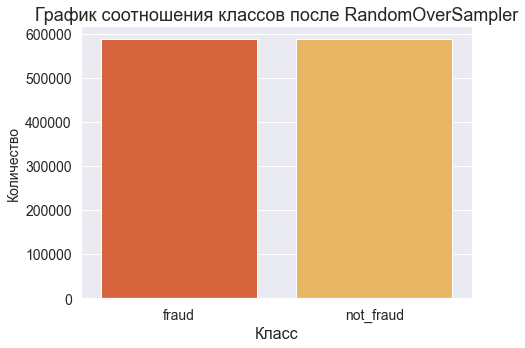

In [24]:
plt.figure(figsize=(7,5))
sns.countplot(x=y_resampled, palette=colors, order=[1,0])
plt.xticks(fontsize=14, ticks=[0,1], labels=['fraud', 'not_fraud'])
plt.yticks(fontsize=14)
plt.title('График соотношения классов после RandomOverSampler', fontsize=18)
plt.xlabel('Класс', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.show()

In [25]:
X_resampled.shape

(1173856, 7)

In [26]:
X_resampled.shape[0] / X.shape[0]

1.9757627985888562

#### Размер выборки увеличился в 2 раза

<a id='part_1_4'></a>
## <span style='color:#00008B'>4. Выберем метрики для оценки качества моделей</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

Поскольку от дисбаланса мы избавились можно взять несколько метрик:

- **Accuracy**
$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

- **F1-score**

$$F1=\frac{2 \cdot Pr \cdot R}{Pr + R}$$

- **ROC-AUC**

<a id='part_1_5'></a>
## <span style='color:#00008B'>5. Стандартизируем и подготовим данные</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

In [27]:
df_obj = X_resampled.select_dtypes(include=['object'])
clmns = [i for i in df_obj.columns]

le = LabelEncoder()

for clmn in clmns:
    X_resampled[clmn] = le.fit_transform(X_resampled[clmn])

In [28]:
X_resampled.head()

,step,customer,age,gender,merchant,category,amount
0,0,210,4,2,30,12,1.713798
1,0,2753,2,2,30,12,3.705737
2,0,2285,4,1,18,12,3.328268
3,0,1650,3,2,30,12,2.904165
4,0,3585,5,2,30,12,3.603322


#### One hote encoding

In [29]:
ohe = OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
)

In [30]:
X_resampled.iloc[:,1:-1]

,customer,age,gender,merchant,category
0,210,4,2,30,12
1,2753,2,2,30,12
2,2285,4,1,18,12
3,1650,3,2,30,12
4,3585,5,2,30,12
...,...,...,...,...,...
1173851,3685,2,1,44,6
1173852,3521,2,1,34,4
1173853,320,3,1,49,10
1173854,1628,6,2,40,13


In [31]:
T = ohe.fit_transform(X_resampled.iloc[:,1:-1])

In [33]:
A = coo_matrix(X_resampled.loc[:,['step', 'amount']].values)

In [34]:
X_ohe = hstack([A,T])

In [35]:
# Разрешенная матрица для простых моделей
X_ohe.shape

(1173856, 4187)

<a id='part_1_6'></a>
## <span style='color:#00008B'>6. Обучим линейную модель LogReg Cross Validation</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

In [36]:
LogRegCV_5 = LogisticRegressionCV(cv=5, random_state=42)

In [37]:
LogRegCV_5.fit(X_ohe, y_resampled)

LogisticRegressionCV(cv=5, random_state=42)

In [40]:
# Сохраним модельку
with open('m1_d1_ohe_LR_cv5.pickle', 'wb') as f:
    pickle.dump(LogRegCV_5, f)

In [262]:
scores_LR = cross_validate(LogRegCV_5, X_ohe, y_resampled, cv=5,
                            scoring=('accuracy', 'f1_micro', 'roc_auc'),
                            return_train_score=True)

In [269]:
print('test_accuracy',
scores_LR['test_accuracy'].mean())

test_accuracy 0.9910295699670566


In [270]:
print('test_f1_micro',
scores_LR['test_f1_micro'].mean())

test_f1_micro 0.9910295699670566


In [271]:
print('test_roc_auc',
scores_LR['test_roc_auc'].mean())

test_roc_auc 0.9982517426707718


<a id='part_1_7'></a>
## <span style='color:#00008B'>7. Выводы по модели LogReg Cross Validation</span>

test_accuracy - 0.9910295699670566

test_f1_micro - 0.9910295699670566

test_roc_auc - 0.9982517426707718

[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

<a id='part_1_8'></a>
## <span style='color:#00008B'>8. Обучим CatBoostClassifier</span>
[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

In [48]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.9, random_state=42)

In [49]:
model_cbc = CatBoostClassifier(iterations=5000,
                           eval_metric='CrossEntropy',
                           learning_rate=0.009,
                           custom_loss=['Accuracy', 'F1', 'AUC'],
                           use_best_model=True,
                           verbose=False)

In [54]:
model_cbc.fit(X_train, y_train,
          verbose=False,
          cat_features=['customer', 'age', 'gender', 'merchant', 'category'],
          eval_set= (X_test, y_test),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [55]:
# Сохраним модельку
with open('m2_d1_CatBoost.pickle', 'wb') as f:
    pickle.dump(model_cbc, f)

In [59]:
y_pred = model_cbc.predict(X_test)

In [62]:
# Accuracy
accuracy_score(y_test, y_pred)

0.9992162608828992

In [61]:
# F1
f1_score(y_test, y_pred, average='micro')

0.9992162608828992

In [63]:
# ROC-AUC
roc_auc_score(y_test, y_pred)

0.9992142796139721

<a id='part_1_9'></a>
## <span style='color:#00008B'>9. Выводы по модели CatBoost Classifier</span>

test_accuracy - 0.9992162608828992

test_f1_micro - 0.9992162608828992

test_roc_auc - 0.9992142796139721

[ВЕРНУТЬСЯ К ЧАСТИ 1](#part_1)

<a id='part_2'></a>
## <span style='color:#4682B4'> Часть 2: ML модели на dataset 2 </span>

[ВЕРНУТЬСЯ В НАЧАЛО](#part_0)

Ссылка на датасет №1
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

# <span style='color:#4682B4'>Эксперименты с dataset 2</span>
### [1. Подготовка числовых данных](#part_2_1)
### [2. Подготовка категориальных данных](#part_2_2)
### [3. Избавимся от дисбаланса в классах](#part_2_3)
### [4. Выберем метрики для оценки качества моделей](#part_2_4)
### [5. Стандартизируем и подготовим данные](#part_2_5)
### [6. Обучим линейную модель LogReg Cross Validation](#part_2_6)
### [7. Выводы по модели LogReg Cross Validation](#part_2_7)
### [8. Обучим CatBoostClassifier](#part_2_8)
### [9. Выводы по модели CatBoost Classifier](#part_2_9)

In [3]:
df = pd.read_csv('6_data/data2.zip')

In [4]:
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


<a id='part_2_1'></a>
## <span style='color:#00008B'>1. Подготовка числовых данных</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

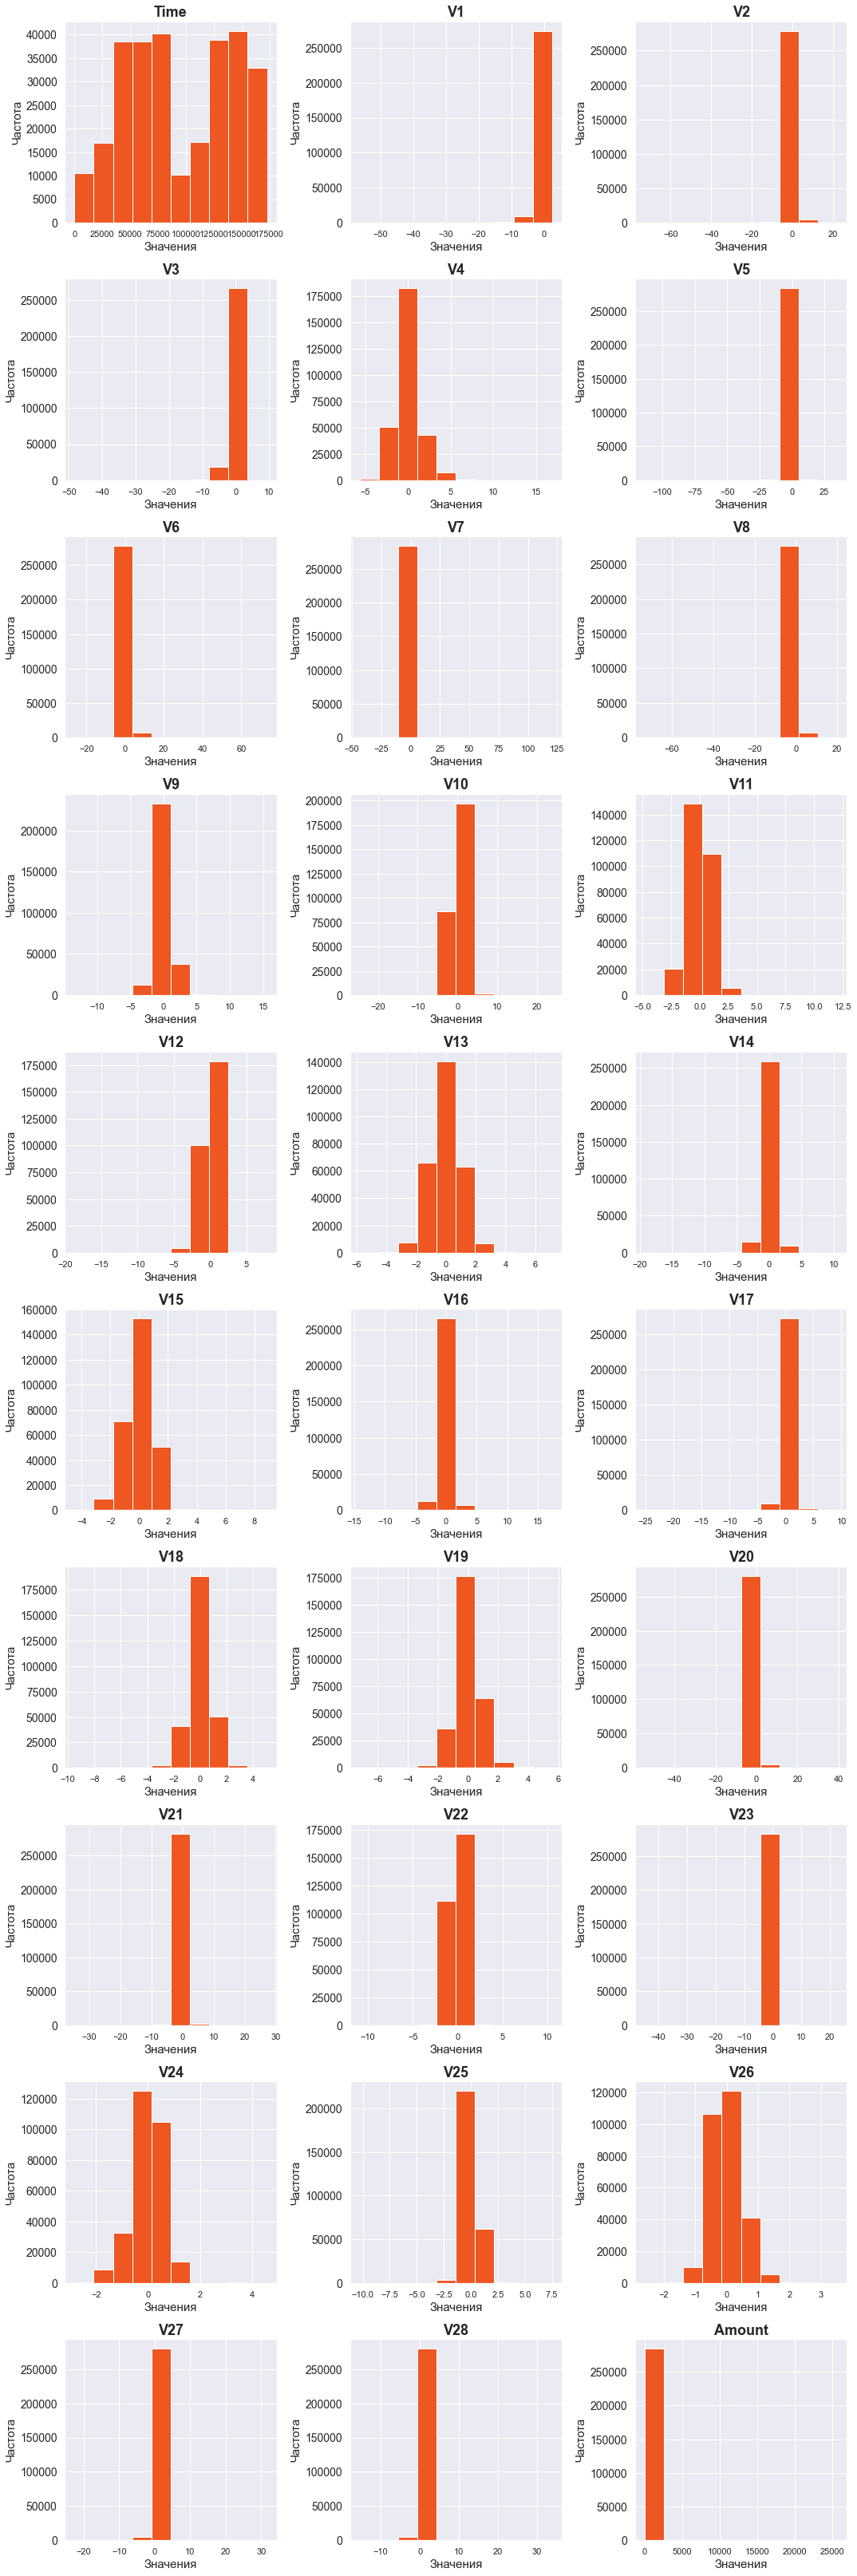

In [12]:
fig, axs = plt.subplots(10, 3, figsize=(15, 45))
for i, ax in enumerate(axs.flat):
    ax.hist(df.iloc[:, i])
    ax.set_title(df.columns.tolist()[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Значения', fontsize=15)
    ax.set_ylabel('Частота', fontsize=15)
    fig.tight_layout()
None

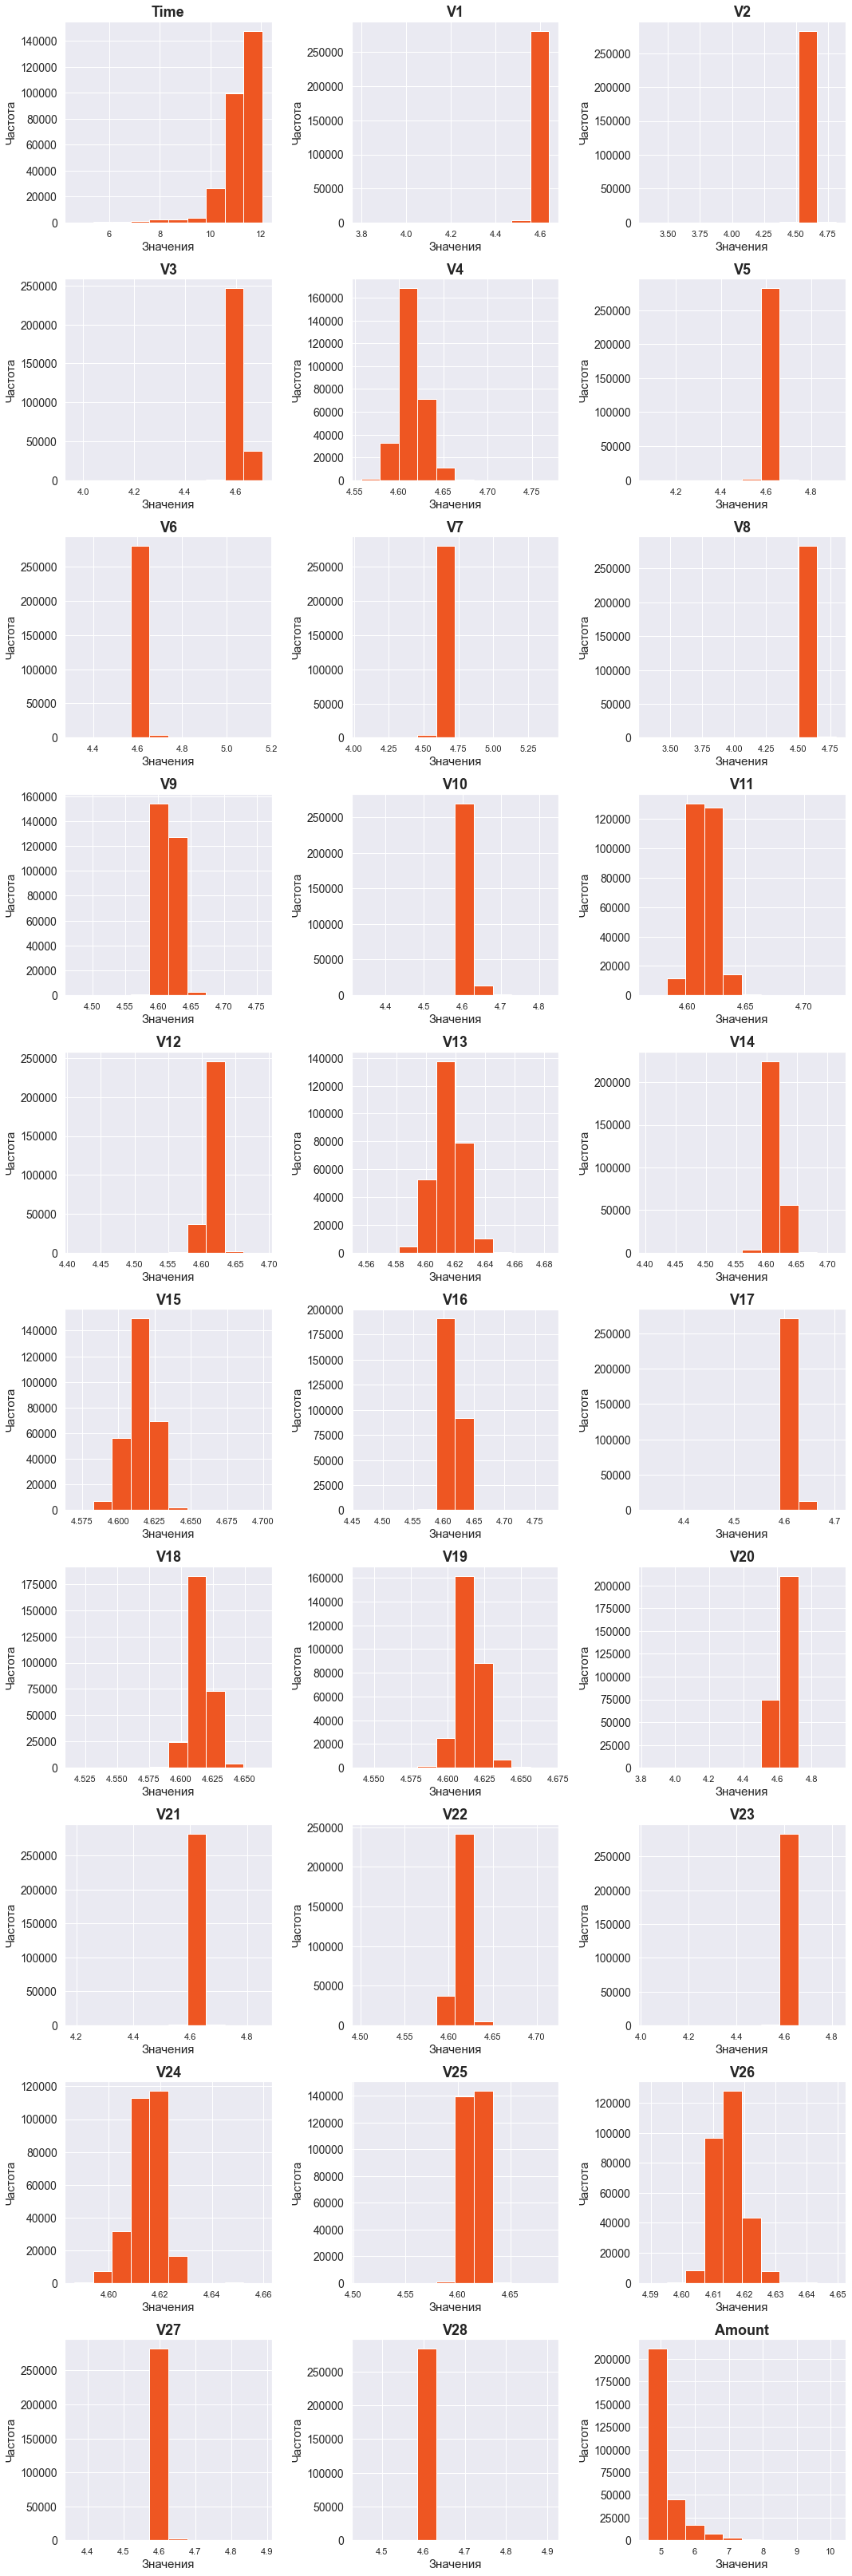

In [31]:
# Возьмем логарифм
fig, axs = plt.subplots(10, 3, figsize=(15, 45))
for i, ax in enumerate(axs.flat):
    ax.hist(np.log1p(df.iloc[:, i]+100))
    ax.set_title(df.columns.tolist()[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Значения', fontsize=15)
    ax.set_ylabel('Частота', fontsize=15)
    fig.tight_layout()
None

**Вывод**

Логарифмирование со смещением не дало результата

#### <span style='color:#00008B'>Попробуем обрезать все переменные и посмотрим на количество фрода</span>

In [162]:
cols = df.columns.tolist()[1:-1]

In [168]:
trim_cols = {}
def quantile_analize(columns):
    for col in columns:
        num_target = df[(df[f'{col}'] > df[f'{col}'].quantile(.02)) & (df[f'{col}'] < df[f'{col}'].quantile(.98))].Class.value_counts().values[1]
        trim_cols[col] = num_target

In [169]:
quantile_analize(cols)

In [178]:
{k: v for k, v in sorted(trim_cols.items(), key=lambda item: item[1], reverse=True)}

{'V24': 486,
 'V13': 468,
 'V26': 468,
 'V15': 451,
 'V22': 434,
 'Amount': 414,
 'V25': 411,
 'V20': 399,
 'V23': 382,
 'V19': 350,
 'V1': 337,
 'V8': 308,
 'V28': 307,
 'V21': 290,
 'V6': 278,
 'V5': 274,
 'V27': 267,
 'V9': 244,
 'V18': 244,
 'V2': 238,
 'V4': 212,
 'V7': 179,
 'V3': 161,
 'V16': 139,
 'V11': 121,
 'V12': 109,
 'V10': 85,
 'V17': 85,
 'V14': 71}

**Вывод**
Можно обрезать только первые 4 переменные и по меньшему порогу

#### <span style='color:#00008B'>Переменная V13</span>

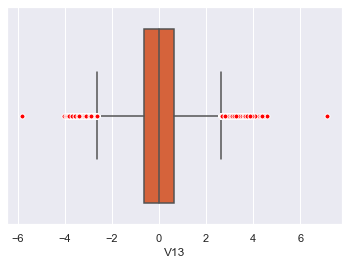

In [129]:
# Посмотрим на коробчатую диаграмму
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
sns.boxplot(df.V13, flierprops=red_circle);

Обрежим выбросы и посмотрим на таргет

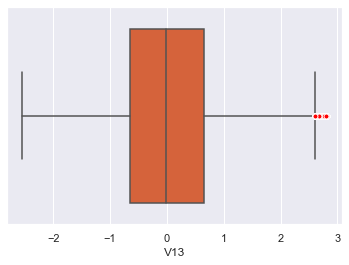

In [187]:
# Если обрезать по квантилю 0,01 и 0,99
sns.boxplot(df[(df.V13 > df.V13.quantile(.005)) & (df.V13 < df.V13.quantile(.995))].V13, flierprops=red_circle);

In [186]:
df[(df.V13 > df.V13.quantile(.005)) & (df.V13 < df.V13.quantile(.995))].Class.value_counts()

0    281472
1       485
Name: Class, dtype: int64

In [133]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Вывод
Эту переменную можно обрезать (0.005 и 0.995)

#### <span style='color:#00008B'>Переменная V15</span>

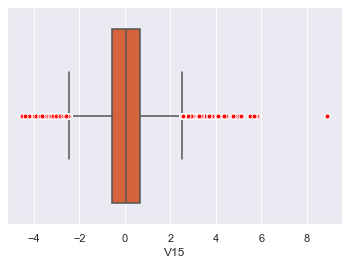

In [140]:
# Посмотрим на коробчатую диаграмму
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
sns.boxplot(df.V15, flierprops=red_circle);

Обрежим выбросы и посмотрим на таргет

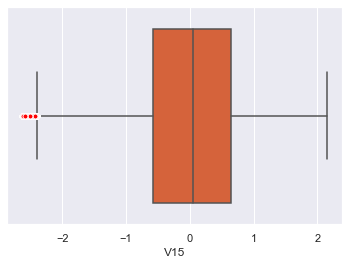

In [146]:
# Если обрезать по квантилю 0,005 и 0,995
sns.boxplot(df[(df.V15 > df.V15.quantile(.005)) & (df.V15 < df.V15.quantile(.995))].V15, flierprops=red_circle);

In [147]:
df[(df.V15 > df.V15.quantile(.005)) & (df.V15 < df.V15.quantile(.995))].Class.value_counts()

0    281477
1       480
Name: Class, dtype: int64

#### Вывод
Эту переменну тоже можно обрезать по уровням (0,005 и 0,995)

#### <span style='color:#00008B'>Переменная V24</span>

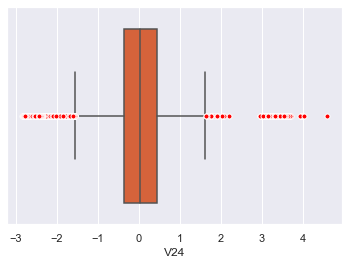

In [179]:
# Посмотрим на коробчатую диаграмму
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
sns.boxplot(df.V24, flierprops=red_circle);

Обрежим выбросы и посмотрим на таргет

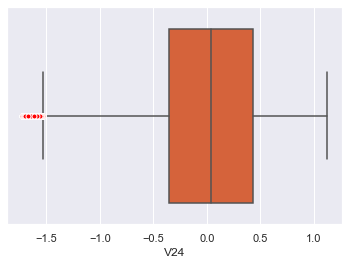

In [182]:
# Если обрезать по квантилю 0,005 и 0,995
sns.boxplot(df[(df.V24 > df.V24.quantile(.005)) & (df.V24 < df.V24.quantile(.995))].V24, flierprops=red_circle);

In [191]:
df[(df.V24 > df.V24.quantile(.005)) & (df.V24 < df.V24.quantile(.995))].Class.value_counts()

0    278654
1       483
Name: Class, dtype: int64

#### Вывод
Обрезаем по порогу (0,005 и 0,995)

#### <span style='color:#00008B'>Переменная V26</span>

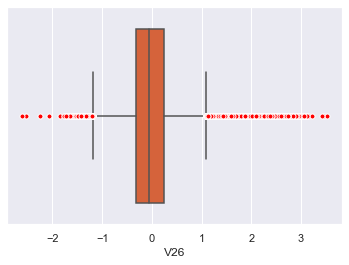

In [183]:
# Посмотрим на коробчатую диаграмму
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
sns.boxplot(df.V26, flierprops=red_circle);

Обрежим выбросы и посмотрим на таргет

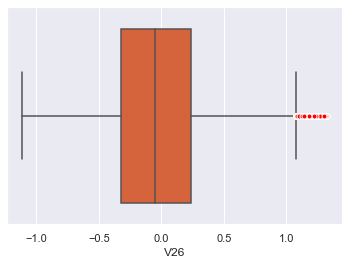

In [184]:
# Если обрезать по квантилю 0,005 и 0,995
sns.boxplot(df[(df.V26 > df.V26.quantile(.005)) & (df.V26 < df.V26.quantile(.995))].V26, flierprops=red_circle);

In [190]:
df[(df.V26 > df.V26.quantile(.005)) & (df.V26 < df.V26.quantile(.995))].Class.value_counts()

0    278658
1       479
Name: Class, dtype: int64

#### Вывод
Обрезаем по порогу (0,005 и 0,995)

In [189]:
# Обрезка по 13 переменной
df = df[(df.V13 > df.V13.quantile(.005)) & (df.V13 < df.V13.quantile(.995))]

In [192]:
# Обрезка по 15 переменной
df = df[(df.V15 > df.V15.quantile(.005)) & (df.V15 < df.V15.quantile(.995))]

In [193]:
# Обрезка по 24 переменной
df = df[(df.V24 > df.V24.quantile(.005)) & (df.V24 < df.V24.quantile(.995))]

In [194]:
# Обрезка по 24 переменной
df = df[(df.V26 > df.V26.quantile(.005)) & (df.V26 < df.V26.quantile(.995))]

In [195]:
df.Class.value_counts()

0    273113
1       467
Name: Class, dtype: int64

<a id='part_2_2'></a>
## <span style='color:#00008B'>2. Подготовка категориальных данных</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

In [199]:
df.Time

0              0.0
1              0.0
3              1.0
4              2.0
5              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 273580, dtype: float64

<a id='part_2_3'></a>
## <span style='color:#00008B'>3. Избавимся от дисбаланса в классах</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

<a id='part_2_4'></a>
## <span style='color:#00008B'>4. Выберем метрики для оценки качества моделей</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

<a id='part_2_5'></a>
## <span style='color:#00008B'>5. Стандартизируем и подготовим данные</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

<a id='part_2_6'></a>
## <span style='color:#00008B'>6. Обучим линейную модель LogReg Cross Validation</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

<a id='part_2_7'></a>
## <span style='color:#00008B'>7. Выводы по модели LogReg Cross Validation</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

<a id='part_2_8'></a>
## <span style='color:#00008B'>8. Обучим CatBoostClassifier</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)

<a id='part_2_9'></a>
## <span style='color:#00008B'>9. Выводы по модели CatBoost Classifier</span>

[ВЕРНУТЬСЯ К ЧАСТИ 2](#part_2)